# Kinematic Bicycle Model #
## Dynamics ## 
(Note we are using the center of gravity as a reference)
$$ 
x = \begin{bmatrix}
      p_x \\ p_y \\ \theta \\ \delta \\ v
\end{bmatrix}, \quad
u = \begin{bmatrix}
    \alpha \\ \phi
\end{bmatrix}, \quad 
\dot{x} = 
\begin{bmatrix}
    v\cos\theta \\ v\sin\theta \\ 
    \frac{v}{L}\cos\beta\tan\delta \\ \phi \\ \alpha
\end{bmatrix} $$
where
$(p_x, p_y)$ is the position of the center of mass, $\theta$ is the yaw, $\delta$ is the steering angle, $L$ is the distance between the front and rear wheels, $\beta = \tan^{-1}(\ell_r * \delta, L)$ is the , and $\ell_r$ is the length form the center of mass to the rear wheel. 



In [1]:
using ForwardDiff, LinearAlgebra
using Plots, Printf    # For showing results

## Generate Reference Trajectory 

In [130]:
# const x0 = [0.0; 0.0; 0.0; 0.0; 2.0]
const nx = 5   # Number of states 
const nu = 2   # Number of controls 


# THESE MAY NEED TO CHANGE DEPENDING ON TRAJECTORY
const Q = Diagonal([1000.0 * ones(2); fill(0.1, 3)]) # Penalize (x, y) error 
const R = Diagonal(fill(1e3, nu))          # 
const Qf = Diagonal([1000.0 * ones(2); fill(0.001, 3)])  # Don't care about terminal θ, δ, or v

const dt = 1.0
# const N = 101

1.0

In [140]:
function triangleWave(N; freq = (1/10), slope = 0.25 ) 
    """ Makes a triangular wave by using the sign of a sine """
    w = zeros(N)
    signs = zeros(N)
    signs[1] = 1
    for i = 1:N-1
        signs[i + 1] = sign(sin(i * freq))
        w[i + 1] = w[i] + signs[i + 1] * slope
    end
    
    return w, signs
end;

# w, s = triangleWave(101)
# plot(w)

In [141]:
dt

0.5

In [142]:
# Sinusoidal Y
px₀, py₀, θ₀, δ₀, v₀ = 1.0, 0.0, 0.0, 0.0, 2.0
v̄ = 0.5   # Desired velocity
const x0 = [px₀, py₀, θ₀, δ₀, v₀]
# pxs = [px₀ + (i * v̄) for i = 1:N-1 ];           pushfirst!(pxs, px₀)
# pys = [py₀ + (5 * sin(i / 15)) for i = 1:N-1];  pushfirst!(pys, py₀)
# θs  = [0 for i = 1:N-1];                         pushfirst!(θs, θ₀)
# # θs  = [atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N-1];                        pushfirst!(θs, θ₀)
# δs  = [0 for i = 1:N-1];                        pushfirst!(δs, δ₀)
# vs  = [v₀ + v̄ for i = 1:N-1];                   pushfirst!(vs, v₀)
# Xref = [ [pxs[i]; pys[i]; θs[i]; δs[i]; vs[i]] for i = 1:N]
Xref = [ [i; 10 * sin(i / 15); 0.0; 0.0; 1.0 / dt ] for i = 1:N]  

Uref = [ 0.01 * randn(2) + [0.0; 0.0] for i = 1:N-1]

# # Make a square wave / sharp turns 
# tWave, tSigns = triangleWave(N; freq = (1/20), slope = 0.1 )
# Xref = [ [i/5; tWave[i]; tSigns[i] * deg2rad(45); 0.0; (0.25 / dt) ] for i = 1:N]


Xrefm = hcat(Xref...)'
display(plot(Xrefm, title = "Reference"))
display(plot(Xrefm[:, 1], Xrefm[:, 2], title = "X/Y"))
# plot(hcat(Uref...)')

LoadError: cannot declare x0 constant; it already has a value

In [316]:
"""
Calculate the continuous time dynamics ẋ = f(x,u), where 
  x is a vector of length nx, u is a vector of length nu.

returns ẋ
"""

function dynamics(x, u; L = 2, Lr = 1.5)
    # Kinematic Bicycle model (referenced to center of mass)
    
    θ, δ, v = x[3:5]   # Yaw, steering angle, velocity
    α, ϕ    = u        # Longitudinal acceleration, steering angle rate 
    
    β = atan(Lr * δ, L)
    s, c = sincos(θ + β)
    ω = v * cos(β) * tan(δ) / L 
    ẋ = v * c 
    ẏ = v * s 
    
#     return [ẋ; ẏ; ϕ; 0.0; α]
    
    return [ẋ; ẏ; ω; ϕ; α]
end

"""
Integrates the dynamics ODE 1 dt forward, x_{k+1} = rk4(x_k,u_k,dt).

returns x_{k+1}
"""
function rk4(x,u,dt)
    # rk4 for integration
    k1 = dt*dynamics(x, u)
    k2 = dt*dynamics(x + k1/2, u)
    k3 = dt*dynamics(x + k2/2, u)
    k4 = dt*dynamics(x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

"""
uses forward diff to get the following jacobians of the above discrete dynamics function (rk4):
drk4/dx = A 
drk4/du = B
"""
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = ForwardDiff.jacobian(_x -> rk4(_x, u, dt),x)
    B = ForwardDiff.jacobian(_u -> rk4(x, _u, dt),u)
    return A,B
end

dynamics_jacobians

In [251]:
# TASK: Fill out the following methods (10 pts)

function stage_cost(x, u, xref, uref)
    # LQR cost at each knot point (depends on both x and u) (equation provided above)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x, xref)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X, U, Xref, Uref)
    
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:(N-1)
        J += stage_cost(X[i], U[i], Xref[i], Uref[i])
    end
    
    return J + term_cost(X[N], Xref[N])
end
        
function stage_cost_expansion(x, u, xref, uref)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    
    Jₓ = Q * (x - xref) 
    Jᵤ = R * (u - uref) 
    
    Jₓₓ = Q 
    Jᵤᵤ = R 
    
    # Note that ∇ₓᵤJ = 0 = ∇ᵤₓJ
    
    return Jₓₓ, Jₓ, Jᵤᵤ, Jᵤ
end

function term_cost_expansion(x, xref )
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ

    Jₓ = Qf * (x - xref)
    Jₓₓ = Qf
    
    return Jₓₓ, Jₓ
end

term_cost_expansion (generic function with 1 method)

### Forward & Backward Passes

In [252]:
"""
backward pass for iLQR. Inputs are 
    X - current trajectory              Vector{Vector}
    U - current control                 Vector{Vector}
    Xref - trajectory we want to track  Vector{Vector}
    Uref - control we want to track     Vector{Vector}

We will perform the backwards recursion without any regularization. Store the expected cost 
decrease in ΔJ and return the following 
    d - feedforward control             Vector{Vector}
    K - feedback gain matrices          Vector{Matrix}
    P - cost to go quadratic term       Vector{Matrix}
    ΔJ - expected cost decrease         Float
"""

function backward_pass(X, U, Xref, Uref; ρ = 0.0)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:N]     # cost to go quadratic term   ∇ₓₓV
    p = [zeros(nx) for i = 1:N]        # cost to go linear term      ∇ₓV
    d = [zeros(nu) for i = 1:N-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:N-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    # Initial term for P, p 
    P[end], p[end] = term_cost_expansion(X[end], Xref[end])
    
    for i = (N-1):(-1):1
        Jxx, Jx, Juu, Ju = stage_cost_expansion(X[i], U[i], Xref[i], Uref[i])
        A, B = dynamics_jacobians(X[i], U[i], dt)
        
        gx = Jx + A' * p[i + 1] 
        gu = Ju + B' * p[i + 1]
        Gxx = Jxx + A' * P[i + 1] * A 
        Guu = Juu + B' * P[i + 1] * B 
        Gxu = A' * P[i + 1]' * B            
        Gux = B' * P[i + 1] * A
        
        Gxx = Gxx + I * ρ 
        Guu = Guu + I * ρ
        
        d[i] =  Guu \ gu       # d = Gᵤᵤ⁻¹gᵤ 
        K[i] =  Guu \ Gux      # K = Gᵤᵤ⁻¹Gᵤₓ
        
        p[i] = gx  - K[i]' * gu +  K[i]' * Guu * d[i] - Gxu * d[i]
        P[i] = Gxx + K[i]' * Guu * K[i] - Gxu * K[i] - K[i]' * Gux

        ΔJ += gu' * d[i]
    end
    
    return d, K, P, ΔJ    
end

backward_pass (generic function with 1 method)

In [317]:
function forward_pass(X, U, Xref, Uref, K, d, ΔJ; max_linesearch_iters = 20)
    
    J = trajectory_cost(X, U, Xref, Uref)  # Original cost of initial rollout
    
    α = 1.0
    
    Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
    
    num_iters = 0
    while Jn >= (J - 0.01 * α * ΔJ)
        α = 0.5 * α
        Xn, Un, Jn = forward_pass_loop(X, U, Xref, Uref, K, d, α)
        
        num_iters += 1
        if num_iters > max_linesearch_iters
            @warn "Max Linesearch Iterations reached in forward pass!"
            break
        end
    end
    
    return Xn, Un, Jn, α
end


function forward_pass_loop(X, U, Xref, Uref, K, d, α)
    N = size(X, 1)
    
    Xn, Un = deepcopy(X), deepcopy(U)
    
    for i = 1:(N - 1)
        Un[i] = U[i] - α * d[i] - K[i] * (Xn[i] - X[i])  
        Xn[i + 1] = rk4(Xn[i], Un[i], dt) 
    end
    Jn = trajectory_cost(Xn, Un, Xref, Uref)
    
    return Xn, Un, Jn 
end

forward_pass_loop (generic function with 1 method)

In [318]:
"""
iLQR will combine the backward and forward passes for the complete iLQR algorithm. We will classify 
convergence as when the maximum norm of each feedforward control input in d is below atol. (this is given)

inputs:
    x0 - initial condition Vector
    U - initial control history Vector{Vector}
    Xref - reference trajectory we are trying to track Vector{Vector}
    Uref - reference controls we are trying to track Vector{Vector}

outputs:
    X - optimal trajectory Vector{Vector}
    U - optimal control trajectory Vector{Vector}
    K - feedback gain matrices Vector{Matrix}
    P - cost to go hessians Vector{Matrix}
    iter - iterations it took to converge Int
"""
function iLQR(x0, U, Xref, Uref; atol = 1e-4, max_iters = 100, verbose = true)
    
    # initial logging stuff 

    if verbose
        @printf "iter     J\t\t           ΔJ\t\t        |d|\t         α\n"
        @printf "--------------------------------------------------------\n"
    end
    
    P = [zeros(nx,nx) for i = 1:N]       # cost to go quadratic term   ∇ₓₓV
    d = [zeros(nu)    for i = 1:N - 1]   # feedforward control
    K = [zeros(nu,nx) for i = 1:N - 1]   # feedback gain
    X = [zeros(nx)    for i = 1:N]
    iter = -1 

    # Generate inital X using initial U 
    X[1] = copy(x0)
    for i = 1:N - 1  
        X[i + 1] = rk4(X[i], U[i], dt) 
    end
     
    for i = 1:max_iters
        dn, Kn, Pn, ΔJ = backward_pass(X, U, Xref, Uref)
        d .= dn 
        K .= Kn 
        P .= Pn
    
        # Check for termination 
        dMax = maximum(norm.(d))  #maximum([maximum(abs.(d[j])) for j = 1:size(d, 1)])
        if dMax < atol
            println("$i  \t$ΔJ  \t$dMax  ")
            iter = i
            
#             break
            return X, U, Kn, Pn, iter

        end
        
        # Forward pass
        X, U, Jn, α = forward_pass(X, U, Xref, Uref, K, d, ΔJ)
    
        
        if verbose
            println("$i  \t$(round(Jn, digits = 5))  \t$(round(ΔJ, digits = 5))  \t$(round(dMax, digits = 5))  \t$α")
        end
        
        
        if iter == max_iters
            @warn "Max iters hit in iLQR!"
        end
    end

    return X, U, K, P, iter

end
        

iLQR

In [314]:
# RUN 
x0 = Xref[1]
X, U, K, _, _ = iLQR(x0, Uref, Xref, Uref);

iter     J		           ΔJ		        |d|	         α
--------------------------------------------------------
1  	399515.50037  	9.20830813989e7  	45.76926  	1.0
2  	28619.22972  	756198.3784  	6.74743  	1.0
3  	18731.92833  	22869.1722  	1.29798  	1.0
4  	16364.80256  	7238.15955  	1.09326  	0.5
5  	15577.22921  	1504.84243  	0.35571  	1.0
6  	15490.62458  	124.04168  	0.1449  	1.0
7  	15451.45074  	44.80259  	0.06187  	1.0
8  	15426.93255  	27.7613  	0.0528  	1.0
9  	15411.2386  	17.18086  	0.0384  	1.0
10  	15400.47187  	11.6821  	0.03004  	1.0
11  	15392.7587  	8.2725  	0.02282  	1.0
12  	15387.00169  	6.12737  	0.01782  	1.0
13  	15382.57199  	4.68417  	0.01604  	1.0
14  	15379.08373  	3.67136  	0.01577  	1.0
15  	15376.29142  	2.92882  	0.01522  	1.0
16  	15374.03054  	2.36585  	0.01453  	1.0
17  	15372.18581  	1.92739  	0.01372  	1.0
18  	15370.67296  	1.57912  	0.01286  	1.0
19  	15369.42825  	1.29854  	0.01199  	1.0
20  	15368.40208  	1.07029  	0.01111  	1.0
21  	15367.55507  	0.

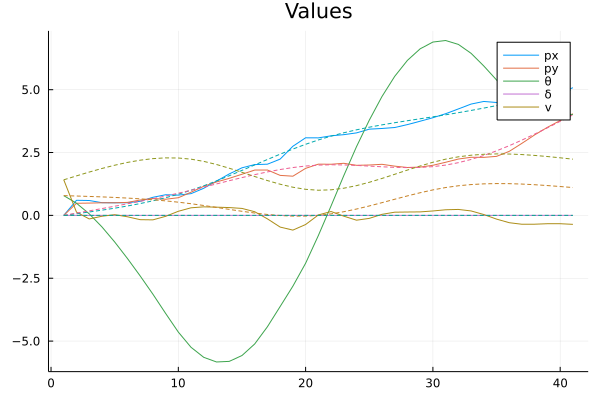

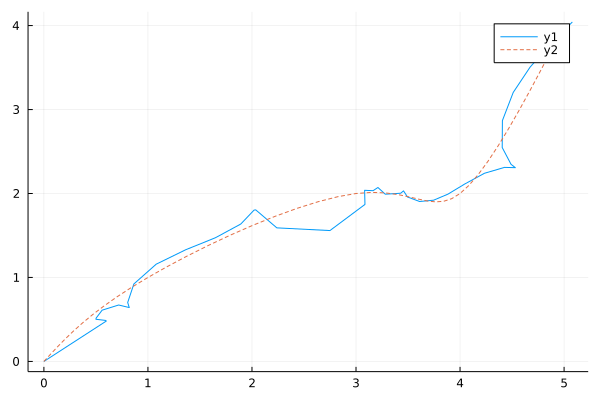

In [315]:
Xrefm = hcat(Xref...)'
a = plot(hcat(X...)', label = ["px" "py" "θ" "δ" "v"])
a = plot!(Xrefm, ls = :dash, label = false, title = "Values")
display(a)


Xm = hcat(X...)'
b = plot(Xm[:, 1], Xm[:, 2])
b = plot!(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
display(b)

## MESHCAT Stuff

In [68]:
# ADD IN MESHCAT WITH COOL SHADOW FOR REAL VS REF
using RobotZoo
using StaticArrays
include("car.jl")

  Activating environment at `~/Classes/16-745_OCRL/Project/Project.toml`


plot_region!

In [98]:
model = RobotZoo.BicycleModel()
vis = initialize_visualizer(model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat /home/benjj/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set{Any}(), ip"127.0.0.1", 8704))

In [100]:
Xref_static = [SVector{nx, Float64}(Xref[i]) for i = 1:N]
X_static    = [SVector{nx, Float64}(X[i]) for i = 1:N]

visualize!(vis, model, N * dt / 4.0, X_static)

In [57]:
# using Colors
# # using TrajOptPlots
# visualize!(vis, model, N * dt / 4, X_static, Xref_static, colors=[colorant"blue", RGBA(0,0,1,0.5)])

### Read in trajectory

In [197]:
function cheating(θ⁺, θ⁻, v, dt; L = 2, Lr = 1.5)
    diff = 1000.0
    bestδ = 0.0
    for δ = -(π-0.2):0.01:(π - 0.2)
        d = abs((L * (θ⁺ - θ⁻)/(v * dt)) - cos(atan(Lr * δ / L)) * tan(δ))
        
        if d < diff 
            diff = d 
            bestδ = δ
        end
    end
    
    return bestδ
end

function newton(θ⁺, θ⁻, v, dt; L = 2, Lr = 1.5, τ = 1e-5, max_iters = 15)
    function residual(δ)
        β = atan(Lr * δ, L)
        est = θ⁻ + (v/L) * cos(β) * tan(δ)
#         est = rk4((v/L) * cos(β) * tan(δ), u, dt) 
        return θ⁺ - est
    end

    δ₀ = (θ⁺ - θ⁻) / dt
    
    for i = 1:max_iters 
        𝐉 = ForwardDiff.derivative(residual, δ₀)
        Δδ = (𝐉 \ residual(δ₀))
        δ₀ = δ₀ - Δδ
        
        while (δ₀ < -pi)
            δ₀ += pi 
        end
        while (δ₀ > pi)
            δ₀ -= pi
        end
            
        
        if norm(Δδ) < τ
            return δ₀
        end
    end
    
    @warn "Max iters reached in newton!"
    return δ₀
    
end

# function newton2(p⁺, p⁻, dt)
#     function residual(x)
#         return dynamics(x)
#     end
    
# end

newton (generic function with 1 method)

In [319]:
function createRef_2(file::String, dt; verbose = false, L = 2, Lr = 1.5)
    
    pxs, pys = testTraj()
#     pxs, pys = getPositions(file); pxs, pys = pxs[1:50], pys[1:50]
    N = length(pxs)
    
    θs = [ atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N - 1]
    push!(θs, θs[end])
    
    vs = [ sqrt( (pys[i + 1] - pys[i])^2 + (pxs[i + 1] - pxs[i])^2) / (dt)  for i = 1:N - 1 ]
    push!(vs, vs[end]) 
    
    δs = [newton(θs[i + 1], θs[i], vs[i], dt) for i = 1:N - 1]
# #     δs = [ (θs[i + 1] - θs[i] / dt) for i = 1:N - 1]
    push!(δs, δs[end])
#     δs = zeros(N)
    
#     ϕs = [ (δs[i + 1] - δs[i]) / (dt) for i = 1:N - 1]
    ϕs = [ (θs[i + 1] - θs[i]) / dt for i = 1:N - 1]
    ϕs = [ϕs; ϕs[end]]

    αs = [ (vs[i + 1] - vs[i]) / dt for i = 1:N - 1]
    αs = [αs; αs[end]]
    
    
    upSampleRate = 10
    method  = Cubic(Line(OnGrid()))  # Linear()
    ℓ = (N - 1) * upSampleRate + 1
    pxInt = interpolate(pxs, BSpline(method)) 
    pyInt = interpolate(pys, BSpline(method))
    θInt  = interpolate(θs,  BSpline(method))
    δInt  = interpolate(δs,  BSpline(method))
    vInt  = interpolate(vs,  BSpline(method))
    αInt  = interpolate(αs,  BSpline(method))
    ϕInt  = interpolate(ϕs,  BSpline(method))

    pxs = pxInt(range(1, N, length = ℓ)) # .- 100.0  # Center it, for plotting convenience
    pys = pyInt(range(1, N, length = ℓ)) # .- 100.0
    θs  = θInt( range(1, N, length = ℓ))
    δs  = δInt( range(1, N, length = ℓ)) #/ upSampleRate
    vs  = vInt( range(1, N, length = ℓ)) #/ upSampleRate
    αs  = αInt( range(1, N, length = ℓ)) #/ (upSampleRate)
    ϕs  = ϕInt( range(1, N, length = ℓ)) #/ (upSampleRate)
    
    N = length(pxs)
    
#     θs = zeros(N)
#     vs = zeros(N)
#     δs = zeros(N)   # Solving for this from Δθ would be a nightmare  ← can confirm, it is
#     ϕs = 0.1 * randn(N)
#     αs = 0.1 * randn(N)

    Xref = [ [pxs[i], pys[i], θs[i], δs[i], vs[i]] for i = 1:N]
    Uref = [ [αs[i], ϕs[i]] for i = 1:N-1]
    
    return Xref, Uref
end

createRef_2 (generic function with 1 method)

In [320]:
using Interpolations
function testTraj()
    pxs = [0, 1, 3, 4, 5]
    pys = [0, 1, 2, 2, 4]
    return pxs, pys
end

function createRef(file::String, dt; verbose = false, L = 2, Lr = 1.5)
    
    # Convert from a .txt to a matrix 
#     pxs, pys = getPositions(file)
#     pxInt = interpolate(pxs, BSpline(Cubic(Line(OnGrid()))))
#     pyInt = interpolate(pys, BSpline(Cubic(Line(OnGrid()))))

#     upSampleRate = 1
#     pxs = pxInt(range(1, 50, length = 50 * upSampleRate)) # .- 100.0  # Center it, for plotting convenience
#     pys = pyInt(range(1, 50, length = 50 * upSampleRate)) # .- 100.0
    
#     dtn = dt / upSampleRate  # Don't need to go as fast, now...
    
    
    
    pxs, pys = testTraj()
    pxInt = interpolate(pxs, BSpline(Cubic(Line(OnGrid()))))
    pyInt = interpolate(pys, BSpline(Cubic(Line(OnGrid()))))

    upSampleRate = 1
    pxs = pxInt(range(1, 5, length = 5 * upSampleRate)) # .- 100.0  # Center it, for plotting convenience
    pys = pyInt(range(1, 5, length = 5 * upSampleRate)) # .- 100.0
    
    dtn = dt / upSampleRate  # Needs to be adjusted in order to move same distance per time
    
    N = length(pxs)
    
    # Make ref θs by using consecutive pairs of points
    θs = [ atan(pys[i + 1] - pys[i], pxs[i + 1] - pxs[i]) for i = 1:N - 1]
    push!(θs, θs[end])  # Just add the last angle again to match length 

    # Make ref vs by using the amount of change occuring per time step
    vs = [ sqrt( (pys[i + 1] - pys[i])^2 + (pxs[i + 1] - pxs[i])^2) / (dtn)  for i = 1:N - 1 ]
    push!(vs, vs[end])    
    
    δs = zeros(N)
#     for i = 1:N - 1
#         δs[i + 1] = newton(θs[i + 1], [pxs[i], pys[i], θs[i], δs[i], vs[i]], vs[i], dtn)
#     end
    δs = [newton(θs[i + 1], θs[i], vs[i], dtn) for i = 1:N - 1]
#     δs = [ (θs[i + 1] - θs[i] / dt) for i = 1:N - 1]
    push!(δs, δs[end])
    
    ϕs = [ (δs[i + 1] - δs[i]) / (dtn) for i = 1:N - 1]
    ϕs = [ϕs; ϕs[end]]

    αs = [ (vs[i + 1] - vs[i]) / (dtn) for i = 1:N - 1]
    αs = [αs; αs[end]]
    
    
    
#     θs = zeros(N)
#     vs = zeros(N)
#     δs = zeros(N)   # Solving for this from Δθ would be a nightmare  ← can confirm, it is
#     ϕs = 0.1 * randn(N)
#     αs = 0.1 * randn(N)
    

    Xref = [ [pxs[i], pys[i], θs[i], δs[i], vs[i]] for i = 1:N]
    Uref = [ [αs[i], ϕs[i]] for i = 1:N-1]
    
    return Xref, Uref
end


function getPositions(file::String)
    pos = []
    open(file) do f

        # read till end of file

        while ! eof(f) 

            s = readline(f)  # Read in a row of data

            s = parse.(Float64, split(s, " "))  # Separate by spaces, and then convert to a float

            push!(pos, s)  # Add to the vector
        end
    end

    pos = hcat(pos...)'
    
    return pos[:, 1], pos[:, 2]
end

using Plots
file = "../logs/curvy_traj.txt" #"../logs/trajectory_good4.txt"
Xref, Uref = createRef_2(file, dt);
N = size(Xref, 1)


41

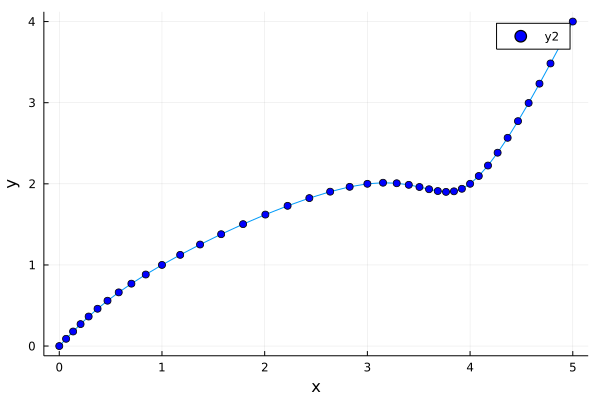

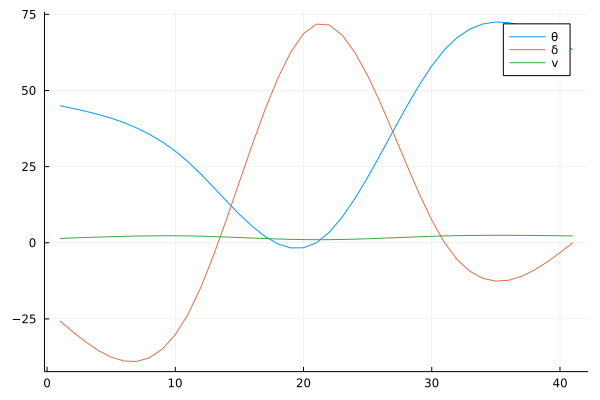

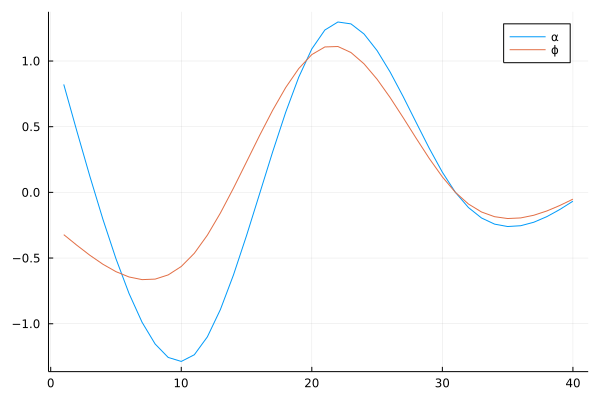

In [321]:
Xrefm = hcat(Xref...)'
plot(Xrefm[:, 1], Xrefm[:, 2], label = false)
display(scatter!(Xrefm[:, 1], Xrefm[:, 2], xlabel = "x", ylabel = "y", color = :blue))

plot(rad2deg.(Xrefm[:, 3]), label = "θ")
plot!(rad2deg.(Xrefm[:, 4]), label = "δ")
display(plot!(Xrefm[:, 5], label = "v"))

Urefm = hcat(Uref...)'
display(plot(Urefm, label = ["α" "ϕ"]))

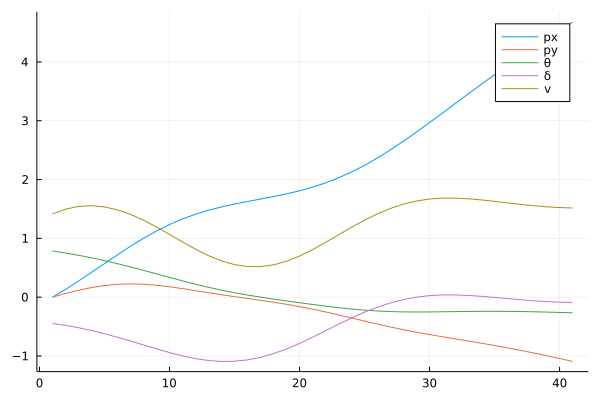

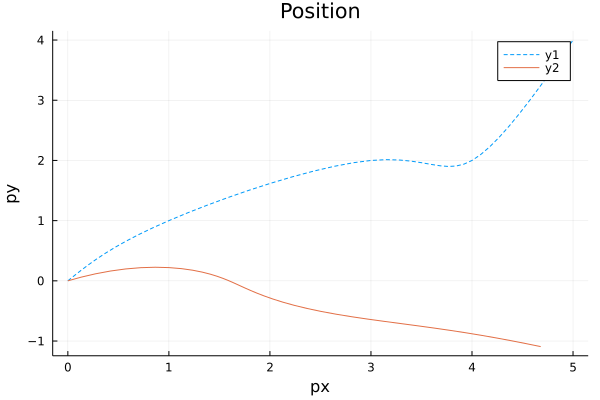

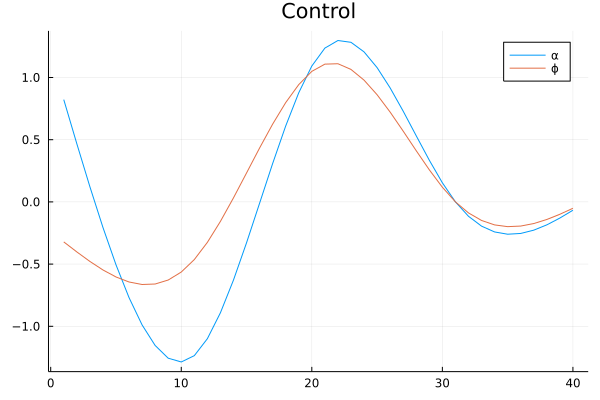

norm(posError(Xr, Xref)) = 16.277260619529876


16.277260619529876

In [322]:
function wrap(X)
    x, y, θ, δ, v = X
    # θ 
    while (θ > pi)
        θ -= pi
    end
    
    while (θ < -pi)
        θ += pi
    end
    
    # δ
    while (δ > pi)
        δ -= pi
    end
    
    while (δ < -pi)
        δ += pi
    end
    
    return [x, y, θ, δ, v]
    
end

function rollout(x0, Uref, dt)
    X = [x0 for i = 1:size(Uref, 1) + 1]
    X[1] = x0 
    
    for i = 1:size(X, 1) - 1
        Xn = rk4(X[i], Uref[i], dt) 
        X[i + 1] = wrap(Xn)
    end
    return X
end

function posError(X, Xref)
    N = size(X, 1)
    Xm = hcat(X...)
    Xrefm = hcat(Xref...)
    
    error = 0.0
    errs = zeros(N)
    for i = 1:N
        errs[i] = norm(Xm[1:2, i] - Xrefm[1:2, i])
        error += errs[i]
    end
    return errs
end

Xr = rollout(Xref[1], Uref, dt / 10.0)


Xrm = hcat(Xr...)'
Xrefm = hcat(Xref...)'

# plot(Xrm[:, 1], Xrm[:, 2])
display(plot(Xrm, label = ["px" "py" "θ" "δ" "v"]))

plot(Xrefm[:, 1], Xrefm[:, 2], ls = :dash)
display(plot!(Xrm[:, 1], Xrm[:, 2], title = "Position", xlabel = "px", ylabel = "py"))
display(plot(hcat(Uref...)', title = "Control", label = ["α" "ϕ"]))
# plot(Xrm[:, 3])
# display(scatter!(Xrefm[:, 3], ls = :dash))
# plot(Xrm[:, 5])
# @show posError(Xr, Xref)
@show norm(posError(Xr, Xref))

In [323]:
[(Uref[i][1], rad2deg(Uref[i][2])) for i = 1:size(Uref, 1)]

40-element Vector{Tuple{Float64, Float64}}:
 (0.8218544151266945, -18.434948822922006)
 (0.46752724491285047, -23.047307302324537)
 (0.12220219172635276, -27.429402251788456)
 (-0.20511862740545578, -31.350970141375175)
 (-0.505433095455228, -34.581747441146085)
 (-0.7697390953956204, -36.89147062116261)
 (-0.989034510199287, -38.0498761514861)
 (-1.1543172228388818, -37.82670050217799)
 (-1.256585116287061, -35.99168014329967)
 (-1.2868360735164786, -32.31455154491255)
 (-1.2360679774997898, -26.56505117707799)
 (-1.0997507698893685, -18.645048937441857)
 (-0.8912426270564642, -8.984948433987773)
 ⋮
 (0.3347790615924592, 14.765143561923459)
 (0.1535284981833407, 6.746714935388584)
 (1.1102230246251565e-16, 3.3130777931911634e-15)
 (-0.11574224695643862, -5.079292789789879)
 (-0.19493431066347636, -8.55459838280404)
 (-0.2416373225932674, -10.604137578684167)
 (-0.2599124142179683, -11.406131177072046)
 (-0.2538207170097347, -11.138799977609423)
 (-0.22742336244072237, -9.9803647799380

In [271]:
# Xref